In [230]:
# DATA2001 Assignment

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# Assignment

In [231]:
from sqlalchemy import create_engine, text, types
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import geoalchemy2
import geopandas as gpd
import requests
from shapely.geometry import mapping, point
import time
import matplotlib.pyplot as plt


credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [232]:
db, conn = pgconnect(credentials)
conn.execute(text("set search_path to public"))

Connected successfully.


### Loading Data into Python from .csv, .txt and .shp

In [233]:
data_path = "data"

population_df = pd.read_csv(f"{data_path}/Population.csv")
businesses_df = pd.read_csv(f"{data_path}/Businesses.csv")
income_df = pd.read_csv(f"{data_path}/sa2_income.csv")
postcode_df = pd.read_csv(f"{data_path}/sa2_postcode.csv")
stops_df = pd.read_csv(f"{data_path}/Stops.txt")

sa2_gdf = gpd.read_file(f"{data_path}/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
primary_catchments = gpd.read_file(f"{data_path}/catchments/catchments_primary.shp")
secondary_catchments = gpd.read_file(f"{data_path}/catchments/catchments_secondary.shp")

### Data cleaning before ingestion into database

### Cleaning population

In [234]:
cleaned_population_df = population_df.copy()

cleaned_population_df.columns = (
    cleaned_population_df.columns
    .str.lower()
    .str.replace('-', '_')
    .str.replace(' ', '_')
)


### Cleaning Businesses

In [235]:
cleaned_businesses_df = businesses_df.copy()
for col in cleaned_businesses_df.select_dtypes(include="object"):
    cleaned_businesses_df[col] = cleaned_businesses_df[col].str.strip()
cleaned_businesses_df.rename(columns={
    "0_to_50k_businesses": "b_0_50k",
    "50k_to_200k_businesses": "b_50k_200k",
    "200k_to_2m_businesses": "b_200k_2m",
    "2m_to_5m_businesses": "b_2m_5m",
    "5m_to_10m_businesses": "b_5m_10m",
    "10m_or_more_businesses": "b_10m_plus",
    "total_businesses": "total"
}, inplace=True)


### Cleaning Income

In [236]:
cleaned_income_df = income_df.copy()

cleaned_income_df.rename(columns={
    "SA2_code": "sa2_code",
    "SA2_name": "sa2_name"
}, inplace=True)
cleaned_income_df['income_earners'].fillna(cleaned_income_df['income_earners'].median(), inplace=True)
cleaned_income_df['median_income'].fillna(cleaned_income_df['median_income'].median(), inplace=True)
cleaned_income_df['mean_income'].fillna(cleaned_income_df['mean_income'].median(), inplace=True)
cleaned_income_df['gini_coefficient'].fillna(cleaned_income_df['gini_coefficient'].median(), inplace=True)

/var/folders/7w/0bgjmph51g3fjv7yfs8y17xc0000gn/T/ipykernel_46580/4119000927.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_income_df['income_earners'].fillna(cleaned_income_df['income_earners'].median(), inplace=True)
/var/folders/7w/0bgjmph51g3fjv7yfs8y17xc0000gn/T/ipykernel_46580/4119000927.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

### Cleaning Postcode

In [237]:
cleaned_postcode_df = postcode_df.copy()

postcode_df.rename(columns={
    "SA2_code": "sa2_code",
    "SA2_name": "sa2_name"
}, inplace=True)

### Cleaning Stops

In [238]:
cleaned_stops_df = stops_df.copy()
conn.rollback()

cleaned_stops_df.columns = cleaned_stops_df.columns.str.strip().str.lower()

for col in cleaned_stops_df.select_dtypes(include='object'):
    cleaned_stops_df[col] = cleaned_stops_df[col].str.strip()

columns_to_drop = ['parent_station', 'stop_code', 'platform_code', 'location_type']
cleaned_stops_df = cleaned_stops_df.drop(columns=[col for col in columns_to_drop if col in cleaned_stops_df.columns])


cleaned_stops_df["geometry"] = cleaned_stops_df.apply(
    lambda row: point.Point(row["stop_lon"], row["stop_lat"]), axis=1
)
stops_gdf = gpd.GeoDataFrame(cleaned_stops_df, geometry="geometry", crs="EPSG:4326")

sql = """
SELECT sa2_code21, sa2_name21, sa4_code21, geometry
FROM sa2_boundaries
"""
sa2_gdf = gpd.read_postgis(sql, conn, geom_col="geometry")

stops_gdf = stops_gdf.to_crs(sa2_gdf.crs)

stops_with_sa2 = gpd.sjoin(stops_gdf, sa2_gdf, how="left", predicate="within")
stops_with_sa2 = stops_with_sa2.drop(columns=["stop_lon", "stop_lat", "index_right"])
print(stops_with_sa2.head())

  stop_id                             stop_name  wheelchair_boarding  \
0  200039     Central Station, Eddy Av, Stand A                    0   
1  200054     Central Station, Eddy Av, Stand D                    0   
2  200060                       Central Station                    0   
3  201510                       Redfern Station                    0   
4  201646  Redfern Station, Gibbons St, Stand B                    0   

                      geometry sa2_code21                  sa2_name21  \
0  POINT (151.20666 -33.88221)  117031645  Sydney (South) - Haymarket   
1  POINT (151.20699 -33.88204)  117031645  Sydney (South) - Haymarket   
2  POINT (151.20629 -33.88408)  117031645  Sydney (South) - Haymarket   
3  POINT (151.19887 -33.89169)  117031642                     Redfern   
4  POINT (151.19888 -33.89333)  117031642                     Redfern   

  sa4_code21  
0        117  
1        117  
2        117  
3        117  
4        117  


### Cleaning Geodata

In [239]:
def clean_gdf(gdf):
    gdf = gdf.copy()
    gdf.columns = gdf.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

    for col in gdf.select_dtypes(include="object"):
        gdf[col] = gdf[col].str.strip()

    return gdf

cleaned_sa2_gdf = clean_gdf(sa2_gdf)
cleaned_primary_catchment= clean_gdf(primary_catchments)
cleaned_secondary_catchment = clean_gdf(secondary_catchments)

target_crs = "EPSG:4326"
cleaned_sa2_gdf = cleaned_sa2_gdf.to_crs(target_crs)
cleaned_primary_catchment = cleaned_primary_catchment.to_crs(target_crs)
cleaned_secondary_catchment = cleaned_secondary_catchment.to_crs(target_crs)

cleaned_school_catchment = pd.concat([cleaned_primary_catchment, cleaned_secondary_catchment], ignore_index=True)
cleaned_school_catchment.drop(columns=[
    "kindergart", "year1", "year2", "year3", "year4", "year5", "year6",
    "year7", "year8", "year9", "year10", "year11", "year12", "priority"
], inplace=True)
cleaned_school_catchment.rename(columns={
    "use_id": "school_id",
    "use_desc": "school_name",
    "geometry": "geom"  
}, inplace=True)

### Load in Geodata

### 1.2. Ingestion

We now need to ingest all of the collected data into the database

In [240]:
conn.execute(text("""
DROP TABLE IF EXISTS population CASCADE;
CREATE TABLE population (
    sa2_code BIGINT PRIMARY KEY,
    sa2_name TEXT,
    "0_4_people" INTEGER,
    "5_9_people" INTEGER,
    "10_14_people" INTEGER,
    "15_19_people" INTEGER,
    "20_24_people" INTEGER,
    "25_29_people" INTEGER,
    "30_34_people" INTEGER,
    "35_39_people" INTEGER,
    "40_44_people" INTEGER,
    "45_49_people" INTEGER,
    "50_54_people" INTEGER,
    "55_59_people" INTEGER,
    "60_64_people" INTEGER,
    "65_69_people" INTEGER,
    "70_74_people" INTEGER,
    "75_79_people" INTEGER,
    "80_84_people" INTEGER,
    "85_and_over_people" INTEGER,
    total_people INTEGER
);
                  
DROP TABLE IF EXISTS businesses CASCADE;
CREATE TABLE businesses (
    industry_code TEXT,
    industry_name TEXT,
    sa2_code BIGINT,
    sa2_name TEXT,
    b_0_50k INTEGER,
    b_50k_200k INTEGER,
    b_200k_2m INTEGER,
    b_2m_5m INTEGER,
    b_5m_10m INTEGER,
    b_10m_plus INTEGER,
    total INTEGER,
    PRIMARY KEY (sa2_code, industry_code)

);
                  
DROP TABLE IF EXISTS income CASCADE;
CREATE TABLE income (
    sa2_code BIGINT PRIMARY KEY,
    sa2_name TEXT,
    income_earners FLOAT,
    median_income FLOAT,
    mean_income FLOAT,
    gini_coefficient FLOAT
);
                  
DROP TABLE IF EXISTS postcode CASCADE;
CREATE TABLE postcode (
    postcode INTEGER,
    sa2_code BIGINT,
    sa2_name TEXT,
    PRIMARY KEY (postcode, sa2_code)
);
                  
DROP TABLE IF EXISTS stops CASCADE;
CREATE TABLE stops (
    stop_id TEXT,
    stop_name TEXT,
    sa2_code21 BIGINT,
    sa2_name21 TEXT,
    sa4_code21 INTEGER,
    wheelchair_boarding INTEGER,
    geom geometry(Point, 4326)
);
                  
DROP TABLE IF EXISTS sa2_boundaries CASCADE;
CREATE TABLE sa2_boundaries (
    sa2_code21 TEXT PRIMARY KEY,
    sa2_name21 TEXT NOT NULL,
    sa4_code21 TEXT,
    sa4_name21 TEXT,
    areasqkm21 DOUBLE PRECISION,
    geom geometry(MultiPolygon, 4326)
);
                  
DROP TABLE IF EXISTS school_catchments CASCADE;
CREATE TABLE school_catchments (
    school_id TEXT PRIMARY KEY,
    catch_type TEXT NOT NULL,
    school_name TEXT NOT NULL,
    add_date DATE,
    geom geometry(MultiPolygon, 4326) NOT NULL
);
                  
                  

CREATE INDEX idx_catchments_geom ON school_catchments USING GIST (geom);
"""))
cleaned_population_df.to_sql(
    "population",
    con=conn,
    if_exists='append',
    index=False,
    method='multi',          
    chunksize=1000           
)
cleaned_businesses_df.to_sql(
    "businesses",
    con=conn,
    if_exists='append',
    index=False,
    method='multi',         
    chunksize=1000          
)
cleaned_income_df.to_sql(
    "income",
    con=conn,
    if_exists='append',
    index=False,
    method='multi',         
    chunksize=1000          
)
cleaned_postcode_df.to_sql(
    "postcodes",
    con=conn,
    if_exists='append',
    index=False,
    method='multi',         
    chunksize=1000          
)

cleaned_school_catchment.set_geometry("geom", inplace=True)
stops_with_sa2 = gpd.GeoDataFrame(
    stops_with_sa2,
    geometry=stops_with_sa2["geometry"],  
    crs="EPSG:4326"
)

stops_with_sa2.to_postgis("stops", conn, if_exists="replace", index=False)
cleaned_sa2_gdf.to_postgis("sa2_boundaries", conn, if_exists="replace", index=False)
cleaned_school_catchment.to_postgis("school_catchments", conn, if_exists="replace", index=False)
conn.commit()


## Task 2 - SA2 Point of Interests

### Pull all POIs in a given bounding box from the API

In [241]:
def shapely_to_esri_polygon(geom):
    """
    Converts a shapely Polygon or MultiPolygon to ESRI JSON polygon format.
    """
    if geom.geom_type == 'Polygon':
        return {
            "rings": [list(geom.exterior.coords)],
            "spatialReference": {"wkid": 4326}
        }
    elif geom.geom_type == 'MultiPolygon':
        rings = []
        for poly in geom.geoms:
            rings.append(list(poly.exterior.coords))
        return {
            "rings": rings,
            "spatialReference": {"wkid": 4326}
        }
    else:
        raise ValueError("Unsupported geometry type for ESRI Polygon")


def get_pois_in_polygon(geom):
    esri_geom = shapely_to_esri_polygon(geom)

    params = {
        "geometry": json.dumps(esri_geom),
        "geometryType": "esriGeometryPolygon",
        "inSR": "4326",
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "*",
        "returnGeometry": "true",
        "f": "json"
    }

    url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"

    try:
        response = requests.post(url, data=params)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print("Request failed:", e)
        return {}

### Loop Through each SA2 in SA4

In [242]:
def get_sa2_geometries_by_sa4(sa4_code, conn):
    """
    Queries the PostGIS DB for SA2 geometries belonging to a given SA4 code.
    Returns a GeoDataFrame.
    """
    sql = """
        SELECT *
        FROM sa2_boundaries
        WHERE sa4_code21 = %s
    """
    try:
        # Use tuple (not dict) for params
        gdf = gpd.read_postgis(sql, conn, params=(sa4_code,), geom_col="geometry")
        return gdf
    except Exception as e:
        print("Error loading SA2 geometries:", e)
        return gpd.GeoDataFrame()

In [243]:
def get_pois_for_sa2_bboxes(sa4_code, conn):

    sa2_in_sa4 = get_sa2_geometries_by_sa4(sa4_code, conn)
    print(f"Found {len(sa2_in_sa4)} SA2 regions in SA4 '{sa4_code}'")

    all_pois = []

    for idx, row in sa2_in_sa4.iterrows():
        sa2_code = row['sa2_code21']
        sa2_name = row['sa2_name21']
        bbox_geom = row.geometry.envelope

        print(f"\nQuerying POIs for SA2 code {sa2_code} ({sa2_name}) bounding box...")
        time.sleep(1)

        pois_result = get_pois_in_polygon(bbox_geom)
        features = pois_result.get("features", [])

        print(f"Found {len(features)} POIs in SA2 {sa2_code} bounding box.")

        for f in features:
            attr = f["attributes"]
            attr["sa2_code21"] = sa2_code
            attr["sa2_name21"] = sa2_name
            all_pois.append(attr)

    pois_df = pd.DataFrame(all_pois)
    print(f"\nTotal collected POIs: {len(pois_df)}")
    print(pois_df.head())
    return pois_df
pois_df = get_pois_for_sa2_bboxes('125', conn)

Found 34 SA2 regions in SA4 '125'

Querying POIs for SA2 code 125011475 (Rookwood Cemetery) bounding box...
Found 23 POIs in SA2 125011475 bounding box.

Querying POIs for SA2 code 125011582 (Auburn - Central) bounding box...
Found 100 POIs in SA2 125011582 bounding box.

Querying POIs for SA2 code 125011583 (Auburn - North) bounding box...
Found 59 POIs in SA2 125011583 bounding box.

Querying POIs for SA2 code 125011584 (Auburn - South) bounding box...
Found 52 POIs in SA2 125011584 bounding box.

Querying POIs for SA2 code 125011585 (Berala) bounding box...
Found 50 POIs in SA2 125011585 bounding box.

Querying POIs for SA2 code 125011586 (Lidcombe) bounding box...
Found 173 POIs in SA2 125011586 bounding box.

Querying POIs for SA2 code 125011587 (Regents Park) bounding box...
Found 44 POIs in SA2 125011587 bounding box.

Querying POIs for SA2 code 125011709 (Silverwater - Newington) bounding box...
Found 64 POIs in SA2 125011709 bounding box.

Querying POIs for SA2 code 125011710 

In [244]:
pois_df.to_sql(
    name='pois_from_bboxes',
    con=conn,
    if_exists='replace',  
    index=False  
)
conn.commit()

In [245]:
query

<function __main__.query(conn, sqlcmd, args=None, df=True)>

In [246]:
print(pois_df.head())

   objectid     topoid  poigroup       poitype  \
0      1149  500190037         1      Cemetery   
1      2903  500319085         1      Cemetery   
2     27012  504379674         1   Crematorium   
3     27015  504379685         3   Golf Course   
4     27019  504379689         4  Parking Area   

                                     poiname  \
0                          ROOKWOOD CEMETERY   
1                          ROOKWOOD CEMETERY   
2  ROOKWOOD MEMORIAL GARDENS AND CREMATORIUM   
3                    STRATHFIELD GOLF COURSE   
4                                       None   

                                    poilabel poilabeltype poialtlabel  \
0                          ROOKWOOD CEMETERY        NAMED        None   
1                          ROOKWOOD CEMETERY        NAMED        None   
2  ROOKWOOD MEMORIAL GARDENS AND CREMATORIUM        NAMED        None   
3                    STRATHFIELD GOLF COURSE        NAMED        None   
4                               Parking Area 

## Part 3 - Scores


## Part 4 - Plots

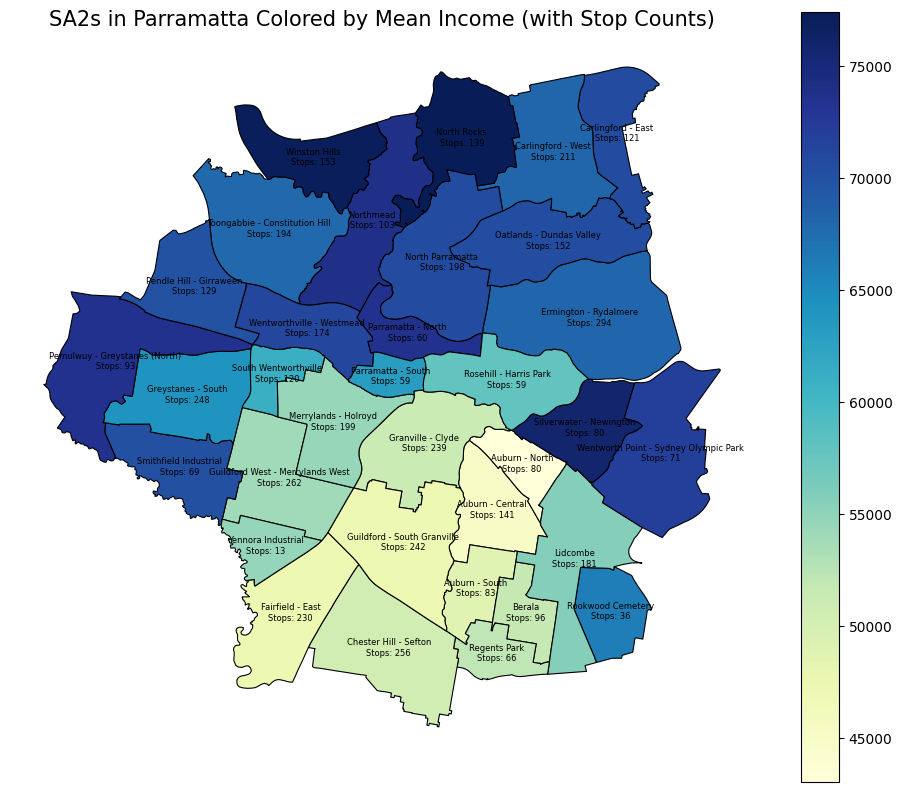

In [247]:
sa4_code = '125'  # Parramatta
conn.rollback()

sql = """
SELECT
    sb.sa2_code21,
    sb.sa2_name21,
    sb.geometry,
    i.mean_income,
    COUNT(s.stop_id) AS stop_count
FROM sa2_boundaries sb
JOIN income i ON sb.sa2_code21 = i.sa2_code::text
LEFT JOIN stops s ON sb.sa2_code21 = s.sa2_code21::text
WHERE sb.sa4_code21 = %s
GROUP BY sb.sa2_code21, sb.sa2_name21, sb.geometry, i.mean_income
"""

# Load into GeoDataFrame
sa2_income_stops_gdf = gpd.read_postgis(sql, conn, params=(sa4_code,), geom_col="geometry")

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Fill areas by mean income
sa2_income_stops_gdf.plot(
    column="mean_income",
    ax=ax,
    cmap="YlGnBu",
    legend=True,
    edgecolor="black",
    linewidth=0.8
)

# Overlay SA2 name and stop count
for idx, row in sa2_income_stops_gdf.iterrows():
    centroid = row.geometry.centroid
    label = f"{row['sa2_name21']}\nStops: {int(row['stop_count'])}"
    ax.text(centroid.x, centroid.y, label, fontsize=6, ha='center', va='center')

ax.set_title("SA2s in Parramatta Colored by Mean Income (with Stop Counts)", fontsize=15)
ax.axis("off")
plt.show()

In [248]:
query(conn, """
DROP TABLE IF EXISTS school_sa2_lookup;
CREATE TABLE school_sa2_lookup AS
SELECT DISTINCT
    sb.sa2_code21,
    sc.school_id
FROM school_catchments sc
JOIN sa2_boundaries sb
    ON ST_Intersects(sc.geom, sb.geometry);
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [250]:
scores_df = query(conn, """WITH base_data AS (
    SELECT
        sb.sa2_code21,
        sb.sa2_name21,
        pop.total_people AS total_population,

        -- Young population: 0–19 years old
        (COALESCE(pop."0_4_people", 0) + COALESCE(pop."5_9_people", 0) +
         COALESCE(pop."10_14_people", 0) + COALESCE(pop."15_19_people", 0)) AS young_population,

        -- Total businesses in key industries
        COALESCE(biz.business_total, 0) * 1000.0 / NULLIF(pop.total_people, 0) AS business_per_1000,

        -- Stops count
        COUNT(DISTINCT s.stop_id) AS stop_count,

        -- Schools per 1000 young people
        COUNT(DISTINCT sc.school_id) * 1000.0 / 
        NULLIF(
            (COALESCE(pop."0_4_people", 0) + COALESCE(pop."5_9_people", 0) +
             COALESCE(pop."10_14_people", 0) + COALESCE(pop."15_19_people", 0)), 
        0) AS schools_per_1000_young,

        -- POIs count (filtered to relevant groups)
        COUNT(DISTINCT p.objectid) AS poi_count

    FROM sa2_boundaries sb
    LEFT JOIN population pop ON sb.sa2_code21::BIGINT = pop.sa2_code

    LEFT JOIN (
        SELECT sa2_code, SUM(total) AS business_total
        FROM businesses
        WHERE industry_name IN ('Health Care and Social Assistance', 'Education and Training', 'Retail Trade')
        GROUP BY sa2_code
    ) biz ON sb.sa2_code21::BIGINT = biz.sa2_code

    LEFT JOIN stops s ON sb.sa2_code21 = s.sa2_code21
    LEFT JOIN (
        SELECT DISTINCT sa2_code21, school_id
        FROM school_sa2_lookup
    ) sc ON sb.sa2_code21 = sc.sa2_code21
    LEFT JOIN pois_from_bboxes p 
        ON sb.sa2_code21 = p.sa2_code21
        AND p.poigroup IN (1, 2, 3)

    WHERE pop.total_people >= 100
    AND sb.sa4_code21 = '125'

    GROUP BY sb.sa2_code21, sb.sa2_name21, pop.total_people,
             pop."0_4_people", pop."5_9_people", pop."10_14_people", pop."15_19_people", biz.business_total
),

z_scores AS (
    SELECT
        *,
        (business_per_1000 - AVG(business_per_1000) OVER()) / NULLIF(STDDEV_POP(business_per_1000) OVER(), 0) AS z_business,
        (stop_count - AVG(stop_count) OVER()) / NULLIF(STDDEV_POP(stop_count) OVER(), 0) AS z_stops,
        (schools_per_1000_young - AVG(schools_per_1000_young) OVER()) / NULLIF(STDDEV_POP(schools_per_1000_young) OVER(), 0) AS z_schools,
        (poi_count - AVG(poi_count) OVER()) / NULLIF(STDDEV_POP(poi_count) OVER(), 0) AS z_poi
    FROM base_data
),

scored AS (
    SELECT *,
        (z_business + z_stops + z_schools + z_poi) AS z_sum,
        1.0 / (1 + EXP(-(z_business + z_stops + z_schools + z_poi))) AS score
    FROM z_scores
)

SELECT *
FROM scored
ORDER BY score DESC;""")



,sa2_code21,sa2_name21,total_population,young_population,business_per_1000,stop_count,schools_per_1000_young,poi_count,z_business,z_stops,z_schools,z_poi,z_sum,score
0,125041717,Parramatta - North,12203,2112,45.562567,60,5.681818,138,4.024432,-1.325269,1.739009,0.726254,5.164426,0.994316
1,125041489,North Parramatta,23070,4861,18.638925,198,3.291504,183,0.310113,0.648104,-0.147771,1.735342,2.545788,0.927290
2,125021477,Ermington - Rydalmere,24809,6114,13.019469,294,3.434740,147,-0.465134,2.020885,-0.034709,0.928072,2.449115,0.920497
3,125011586,Lidcombe,21334,3809,19.593138,181,3.938041,153,0.441753,0.405007,0.362569,1.062617,2.271947,0.906527
4,125041491,Northmead,20423,4788,22.866376,103,3.341688,195,0.893321,-0.710377,-0.108159,2.004432,2.079217,0.888867
5,125031481,Granville - Clyde,23433,5456,15.021551,239,3.115836,132,-0.188932,1.234396,-0.286434,0.591709,1.350740,0.794251
6,125011709,Silverwater - Newington,9336,2219,36.632391,80,4.506534,48,2.792447,-1.039273,0.811306,-1.291922,1.272558,0.781180
7,125031479,Chester Hill - Sefton,20925,6130,13.763441,256,2.283850,135,-0.362497,1.477493,-0.943157,0.658982,0.830820,0.696528
8,125031484,Guildford West - Merrylands West,23124,6670,10.984259,262,1.949025,154,-0.745906,1.563292,-1.207448,1.085041,0.694978,0.667073
9,125031483,Guildford - South Granville,22556,7098,13.477567,242,2.254156,134,-0.401936,1.277296,-0.966595,0.636557,0.545322,0.633050
